# Data extraction and Pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import os
os.chdir('/content/drive/MyDrive/TextMiningProject/Similarity_project')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import spacy
# nlp = spacy.load('en_core_web_sm')#, disable=["tagger", "parser", "ner"])
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from gensim.models import LdaModel
from gensim.corpora import Dictionary

In [6]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051305 sha256=77c8bd01829b9f10a8688462ce706c7c893fe091ee35cb9801dbc769663e7c51
  Stored in directory: /tmp/pip-ephem-wheel-cache-2lv3n2ev/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [7]:
import spacy
# nlp = spacy.load('en_core_web_lg')
import en_core_web_md
nlp = en_core_web_md.load()
# nlp = spacy.load("en_core_web_md") 

## Data pre-processing

In [5]:
trainRaw = pd.read_csv("train.csv")
print(trainRaw.shape)
trainRaw.head(5)

(320552, 8)


,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


In [6]:
# dropping Chinese columns
trainDataI = trainRaw.drop(['title1_zh', 'title2_zh'], axis=1)
trainDataI.head(5)

,id,tid1,tid2,title1_en,title2_en,label
0,0,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


The datapoints per each category are
unrelated    219313
agreed        92973
disagreed      8266
Name: label, dtype: int64


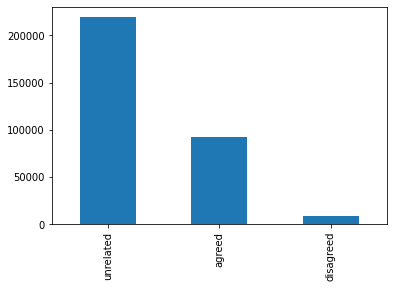

In [7]:
# check the dataset stucture
print('The datapoints per each category are') 
print(trainDataI['label'].value_counts())
trainDataI['label'].value_counts().plot(kind='bar')
plt.show()

## Perform Inital Classification

**Naive bayes classifier**

In [8]:
ddf = trainDataI.copy()
ddf['features'] = ddf.apply(lambda row: row['title1_en'] + row['title2_en'],axis = 1)
dl = pd.Series(['unrelated' if label == 'unrelated' else 'related' for label in trainDataI['label']])
ddf = ddf.drop(['label'], axis=1)
ddf['labelN'] = dl.values
print(ddf.shape)
ddf.head(5)

(320552, 7)


,id,tid1,tid2,title1_en,title2_en,features,labelN
0,0,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",There are two new old-age insurance benefits f...,unrelated
1,3,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,"""If you do not come to Shenzhen, sooner or lat...",unrelated
2,1,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,"""If you do not come to Shenzhen, sooner or lat...",unrelated
3,2,2,5,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,"""If you do not come to Shenzhen, sooner or lat...",unrelated
4,9,6,7,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,"""How to discriminate oil from gutter oil by me...",related


In [9]:
X_train, X_test, y_train, y_test = train_test_split(ddf['features'], ddf['labelN'], test_size=0.30, random_state=42)


In [10]:
vector = TfidfVectorizer(stop_words = 'english')

# Naive Bayes Classifier 
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()

# Pipeline
from sklearn.pipeline import make_pipeline
pipelined = make_pipeline(vector, clf)
Model = pipelined.fit(X_train,y_train)
ModelPred = Model.predict(X_test)

In [11]:
# Evaluation 
from sklearn.metrics import classification_report
report = classification_report(y_test, ModelPred)
print(report)

              precision    recall  f1-score   support

     related       0.58      0.71      0.63     30180
   unrelated       0.85      0.76      0.80     65986

    accuracy                           0.74     96166
   macro avg       0.71      0.73      0.72     96166
weighted avg       0.76      0.74      0.75     96166



**Implementing Logistic Regression**

In [12]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
clfLogit = LogisticRegression(max_iter = 500)#,multi_class = 'multinomial', max_iter = 1000)

# Pipeline
pipelinedLogit = make_pipeline(vector, clfLogit)
ModelLogit = pipelinedLogit.fit(X_train,y_train)
ModelPredLogit = ModelLogit.predict(X_test)

In [13]:
# Evaluation 
reportLogit = classification_report(y_test, ModelPredLogit)
print(reportLogit)

              precision    recall  f1-score   support

     related       0.74      0.54      0.62     30180
   unrelated       0.81      0.91      0.86     65986

    accuracy                           0.79     96166
   macro avg       0.77      0.73      0.74     96166
weighted avg       0.79      0.79      0.78     96166



## Take subset of data and saving in a file

The datapoints per each category are
unrelated    20898
agreed        8347
disagreed      755
Name: label, dtype: int64


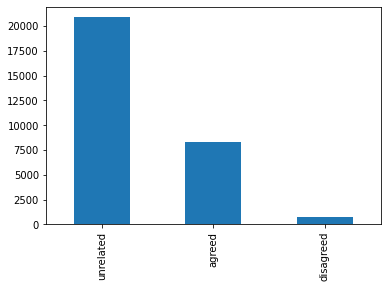

In [14]:
# Subset
trainData = trainDataI[:30000]
# check the dataset stucture of subset
print('The datapoints per each category are') 
print(trainData['label'].value_counts())
trainData['label'].value_counts().plot(kind='bar')
plt.show()

In [15]:
labelsNew = pd.Series(['unrelated' if label == 'unrelated' else 'related' for label in trainData['label']])
df = trainData.copy()
df = df.drop(['label'], axis=1)
df['labelN'] = labelsNew.values
df.head(5)

,id,tid1,tid2,title1_en,title2_en,labelN
0,0,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,related


The datapoints per each category are
unrelated    20898
related       9102
Name: labelN, dtype: int64


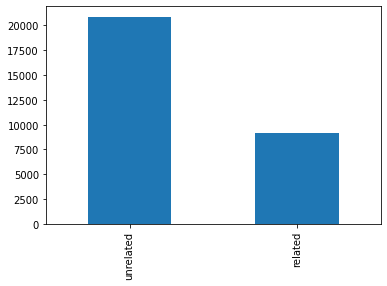

In [16]:
print('The datapoints per each category are') 
print(df['labelN'].value_counts())
df['labelN'].value_counts().plot(kind='bar')

## Pre-process the articles by removing stop words, lemmatization and extracting only alphabets

In [17]:
def preprocess(text):
    tokens = []
    for word in nlp(text):
        if word.is_stop == False and word.lemma_.isalpha():
             tokens.append(word.lemma_)
    return tokens

In [18]:
# df['docA'] = df['title1_en'].apply(preprocess)
# df['docB'] = df['title2_en'].apply(preprocess)

# saving the dataframe  
# df.to_csv('data_preprocessed.csv')  

In [20]:
df = pd.read_csv('data_preprocessed.csv')
df.head(5)

,Unnamed: 0,id,tid1,tid2,title1_en,title2_en,labelN,docA,docB
0,0,0,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,"['new', 'old', 'age', 'insurance', 'benefit', ...","['Police', 'disprove', 'bird', 'nest', 'congre..."
1,1,3,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['Shenzhen', 'gdp', 'outstrip', 'Hong', 'Kong'..."
2,2,1,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['GDP', 'overtop', 'Hong', 'Kong', 'Shenzhen',..."
3,3,2,2,5,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['Shenzhen', 'gdp', 'top', 'Hong', 'Kong', 'ye..."
4,4,9,6,7,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,related,"['discriminate', 'oil', 'gutter', 'oil', 'mean...","['take', 'year', 'cook', 'oil', 'know', 'piece..."


# Context based Similarity - Topic Modelling 

In [9]:
df = pd.read_csv('data_preprocessed.csv')
df.head(5)

,Unnamed: 0,id,tid1,tid2,title1_en,title2_en,labelN,docA,docB
0,0,0,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,"['new', 'old', 'age', 'insurance', 'benefit', ...","['Police', 'disprove', 'bird', 'nest', 'congre..."
1,1,3,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['Shenzhen', 'gdp', 'outstrip', 'Hong', 'Kong'..."
2,2,1,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['GDP', 'overtop', 'Hong', 'Kong', 'Shenzhen',..."
3,3,2,2,5,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['Shenzhen', 'gdp', 'top', 'Hong', 'Kong', 'ye..."
4,4,9,6,7,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,related,"['discriminate', 'oil', 'gutter', 'oil', 'mean...","['take', 'year', 'cook', 'oil', 'know', 'piece..."


## K-means Clustering

In [13]:
# article A
vector = TfidfVectorizer(stop_words = 'english') 
modelAClus = vector.fit(df['title1_en'])
docsAclus = modelAClus.transform(df['title1_en'])

In [14]:
# article B
vector = TfidfVectorizer(stop_words = 'english')
modelBClus = vector.fit(df['title2_en'])
docsBclus = modelBClus.transform(df['title2_en'])

In [15]:
# defining function for kmeans
def kmeansfun(k, docs1, docs2):
    model1 = KMeans(n_clusters=k, n_init=5).fit(docs1)
    model2 = KMeans(n_clusters=k, n_init=5).fit(docs2)
    return model1, model2

In [16]:
# predict function according to the experiment
def predfun(labelsA, labelsB):
    out = []
    for i in range(len(labelsA)):
        if labelsA[i] == labelsB[i]:  
             out.append('related') 
        else:
            out.append('unrelated')
    return out

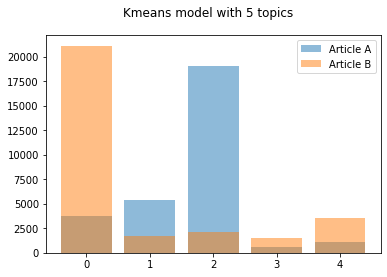

In [29]:
# k = 5
kmeansA5, kmeansB5 = kmeansfun(5, docsAclus, docsBclus)
unique15, counts15 = np.unique(kmeansA5.labels_, return_counts=True)
unique25, counts25 = np.unique(kmeansB5.labels_, return_counts=True)
plt.bar(unique15, counts15, alpha = 0.5, label = 'Article A')
plt.bar(unique25, counts25, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("Kmeans model with 5 topics")
plt.show()

In [18]:
predkmeans5 = predfun(kmeansA5.labels_, kmeansB5.labels_)
crkmeans5 = classification_report(df['labelN'], predkmeans5)
print(crkmeans5)

              precision    recall  f1-score   support

     related       0.32      0.20      0.24      9102
   unrelated       0.70      0.82      0.75     20898

    accuracy                           0.63     30000
   macro avg       0.51      0.51      0.50     30000
weighted avg       0.58      0.63      0.60     30000



In [19]:
Counter(predkmeans5)

Counter({'related': 5611, 'unrelated': 24389})

When minimum number of cluster are considered, say k = 5, there will be lesser topics to consider and most of the times, two articles belong to same cluster. To experiment the theory that was mentioned above, it is really important to cluster the data with broader topic models so that specific models can achieve predictions close to gold labels. Hence, more clusters are considered. 

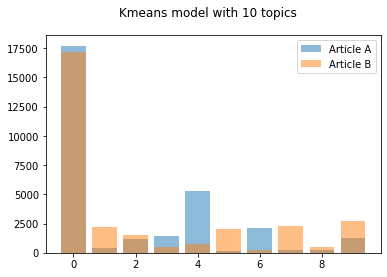

In [30]:
# k = 10
kmeansA10, kmeansB10 = kmeansfun(10, docsAclus, docsBclus)
unique110, counts110 = np.unique(kmeansA10.labels_, return_counts=True)
unique210, counts210 = np.unique(kmeansB10.labels_, return_counts=True)
plt.bar(unique110, counts110, alpha = 0.5, label = 'Article A')
plt.bar(unique210, counts210, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("Kmeans model with 10 topics")
plt.show()

This plot clearly shows that the clustering wasn't great. Using Kmeans for 10, we have achieved maximum number of articles A belong to 1st cluster whereas with article B, 5th cluster has maximum number of documents. So, it can be said that for k = 10, the model is not good. 

In [21]:
predkmeans10 = predfun(kmeansA10.labels_, kmeansB10.labels_)
crkmeans10 = classification_report(df['labelN'], predkmeans10) 
print(crkmeans10)

              precision    recall  f1-score   support

     related       0.27      0.04      0.07      9102
   unrelated       0.69      0.95      0.80     20898

    accuracy                           0.68     30000
   macro avg       0.48      0.50      0.44     30000
weighted avg       0.56      0.68      0.58     30000



In [22]:
Counter(predkmeans10)

Counter({'related': 1322, 'unrelated': 28678})

The accuracy of the model is around 69%. As we can see the recall and f1-score of related class are very low. Accuracy is high because of high number of unrelated class lables

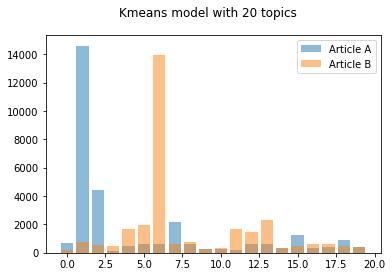

In [31]:
# k = 20
kmeansA20, kmeansB20 = kmeansfun(20, docsAclus, docsBclus)
unique120, counts120 = np.unique(kmeansA20.labels_, return_counts=True)
unique220, counts220 = np.unique(kmeansB20.labels_, return_counts=True)
plt.bar(unique120, counts120, alpha = 0.5, label = 'Article A')
plt.bar(unique220, counts220, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("Kmeans model with 20 topics")
plt.show()

In [24]:
predkmeans20 = predfun(kmeansA20.labels_, kmeansB20.labels_)
crkmeans20 = classification_report(df['labelN'], predkmeans20) 
print(crkmeans20)

              precision    recall  f1-score   support

     related       0.25      0.05      0.08      9102
   unrelated       0.69      0.94      0.80     20898

    accuracy                           0.67     30000
   macro avg       0.47      0.49      0.44     30000
weighted avg       0.56      0.67      0.58     30000



In [25]:
Counter(predkmeans20)

Counter({'related': 1649, 'unrelated': 28351})

Using k = 20, the clusters seems to be improved but the accuracy has been reduced. Even though we have almost equal number of labels predicted, they are not same as the true labels. However, we can see the recall and f1-score of related class are improved.

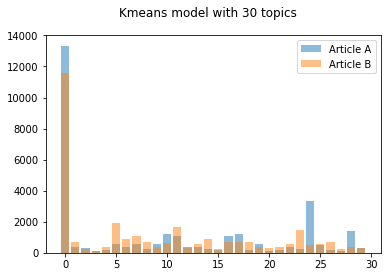

In [32]:
# k = 30
kmeansA30, kmeansB30 = kmeansfun(30, docsAclus, docsBclus)
unique130, counts130 = np.unique(kmeansA30.labels_, return_counts=True)
unique230, counts230 = np.unique(kmeansB30.labels_, return_counts=True)
plt.bar(unique130, counts130, alpha = 0.5, label = 'Article A')
plt.bar(unique230, counts230, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("Kmeans model with 30 topics")
plt.show()

In [27]:
predkmeans30 = predfun(kmeansA30.labels_, kmeansB30.labels_)
crkmeans30 = classification_report(df['labelN'], predkmeans30) 
print(crkmeans30)

              precision    recall  f1-score   support

     related       0.25      0.03      0.05      9102
   unrelated       0.69      0.96      0.81     20898

    accuracy                           0.68     30000
   macro avg       0.47      0.50      0.43     30000
weighted avg       0.56      0.68      0.58     30000



In [28]:
Counter(predkmeans30)

Counter({'related': 1029, 'unrelated': 28971})

Text(0.5, 1.0, 'Kmeans model with 30 topics')

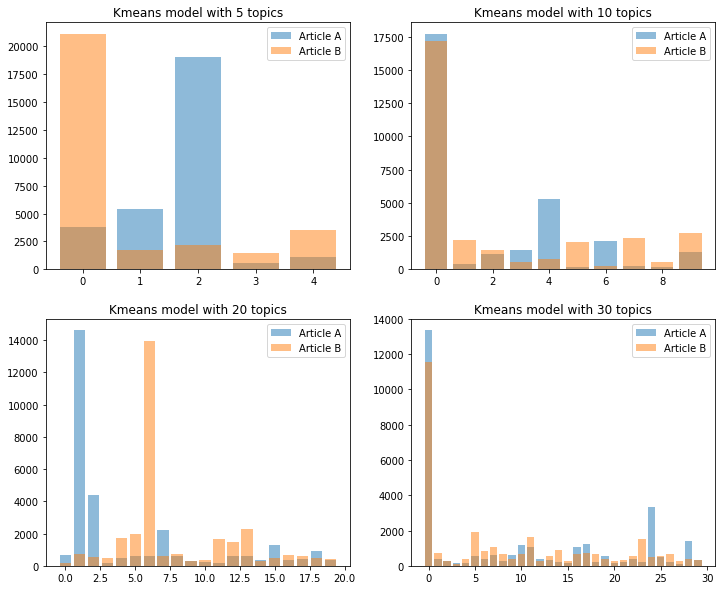

In [38]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(12, 10)

axs[0, 0].bar(unique15, counts15, alpha = 0.5, label = 'Article A')
axs[0, 0].bar(unique25, counts25, alpha = 0.5, label = 'Article B')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_title("Kmeans model with 5 topics")
#plt.show()

axs[0, 1].bar(unique110, counts110, alpha = 0.5, label = 'Article A')
axs[0, 1].bar(unique210, counts210, alpha = 0.5, label = 'Article B')
axs[0, 1].legend(loc='upper right')
axs[0, 1].set_title("Kmeans model with 10 topics")
#plt.show()

axs[1, 0].bar(unique120, counts120, alpha = 0.5, label = 'Article A')
axs[1, 0].bar(unique220, counts220, alpha = 0.5, label = 'Article B')
axs[1, 0].legend(loc='upper right')
axs[1, 0].set_title("Kmeans model with 20 topics")
#plt.show()

axs[1, 1].bar(unique130, counts130, alpha = 0.5, label = 'Article A')
axs[1, 1].bar(unique230, counts230, alpha = 0.5, label = 'Article B')
axs[1, 1].legend(loc='upper right')
axs[1, 1].set_title("Kmeans model with 30 topics")
#plt.show()

## Gaussian Mixture Model

Gaussian Mixture model is a probabilistic approach of k-means clustering where, the classification is done based on multivariate gaussian distribution. Here, each cluster is assumed to be in gaussian distribution and fits the mixture of gaussian models. The experiment is continued for with the same setting used for k-means

In [39]:
print(f'Shape of TF-idf matrix for Article A: {docsAclus.shape}')
print(f'Shape of TF-idf matrix for Article B: {docsBclus.shape}')

Shape of TF-idf matrix for Article A: (30000, 8472)
Shape of TF-idf matrix for Article B: (30000, 16913)


In [40]:
# reduce dimensions of the vectorized matrix
docsAtsne = TSNE(n_components=2, n_iter=500, random_state=32).fit_transform(docsAclus)
docsBtsne = TSNE(n_components=2, n_iter=500, random_state=32).fit_transform(docsBclus)

In [41]:
print(f'Shape of TF-idf matrix for Article A: {docsAtsne.shape}')
print(f'Shape of TF-idf matrix for Article B: {docsBtsne.shape}')

Shape of TF-idf matrix for Article A: (30000, 2)
Shape of TF-idf matrix for Article B: (30000, 2)


In [42]:
def GMMfun(n_comp, docs1, docs2):
    model1 = GaussianMixture(n_components=n_comp, random_state=0).fit_predict(docs1)
    model2 = GaussianMixture(n_components=n_comp, random_state=0).fit_predict(docs2)
    return model1, model2

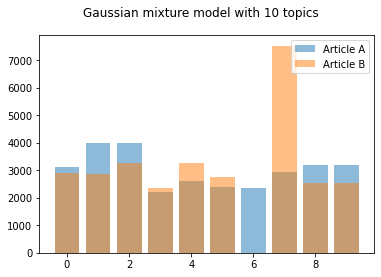

In [43]:
# components = 10
GMMA10, GMMB10 = GMMfun(10, docsAtsne, docsBtsne)
unique110, counts110 = np.unique(GMMA10, return_counts=True)
unique210, counts210 = np.unique(GMMB10, return_counts=True)
plt.bar(unique110, counts110, alpha = 0.5, label = 'Article A')
plt.bar(unique210, counts210, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("Gaussian mixture model with 10 topics")
plt.show()

With 10 components, 

In [44]:
predGMM10 = predfun(GMMA10, GMMB10)
crGMM10 = classification_report(df['labelN'], predGMM10) 
print(crGMM10)

              precision    recall  f1-score   support

     related       0.33      0.11      0.17      9102
   unrelated       0.70      0.90      0.79     20898

    accuracy                           0.66     30000
   macro avg       0.52      0.51      0.48     30000
weighted avg       0.59      0.66      0.60     30000



In [45]:
Counter(predGMM10)

Counter({'related': 3039, 'unrelated': 26961})

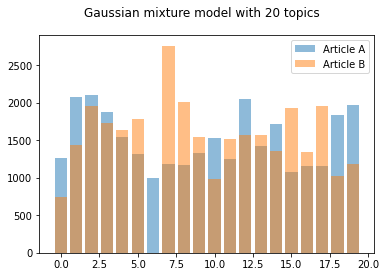

In [46]:
# components = 20
GMMA20, GMMB20 = GMMfun(20, docsAtsne, docsBtsne)
unique120, counts120 = np.unique(GMMA20, return_counts=True)
unique220, counts220 = np.unique(GMMB20, return_counts=True)
plt.bar(unique120, counts120, alpha = 0.5, label = 'Article A')
plt.bar(unique220, counts220, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("Gaussian mixture model with 20 topics")
plt.show()

In [47]:
predGMM20 = predfun(GMMA20, GMMB20)
crGMM20 = classification_report(df['labelN'], predGMM20)
print(crGMM20)

              precision    recall  f1-score   support

     related       0.37      0.07      0.11      9102
   unrelated       0.70      0.95      0.81     20898

    accuracy                           0.68     30000
   macro avg       0.53      0.51      0.46     30000
weighted avg       0.60      0.68      0.60     30000



In [48]:
Counter(predGMM20)

Counter({'related': 1640, 'unrelated': 28360})

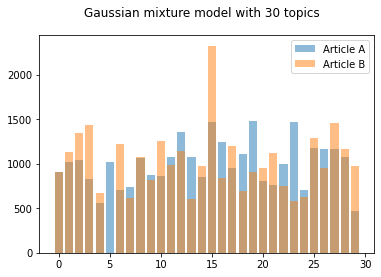

In [49]:
# components = 30
GMMA30, GMMB30 = GMMfun(30, docsAtsne, docsBtsne)
unique130, counts130 = np.unique(GMMA30, return_counts=True)
unique230, counts230 = np.unique(GMMB30, return_counts=True)
plt.bar(unique130, counts130, alpha = 0.5, label = 'Article A')
plt.bar(unique230, counts230, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("Gaussian mixture model with 30 topics")
plt.show()

In [50]:
predGMM30 = predfun(GMMA30, GMMB30)
crGMM20 = classification_report(df['labelN'], predGMM30)
print(crGMM20)

              precision    recall  f1-score   support

     related       0.11      0.01      0.01      9102
   unrelated       0.69      0.97      0.81     20898

    accuracy                           0.68     30000
   macro avg       0.40      0.49      0.41     30000
weighted avg       0.52      0.68      0.57     30000



In [51]:
Counter(predGMM30)

Counter({'related': 611, 'unrelated': 29389})

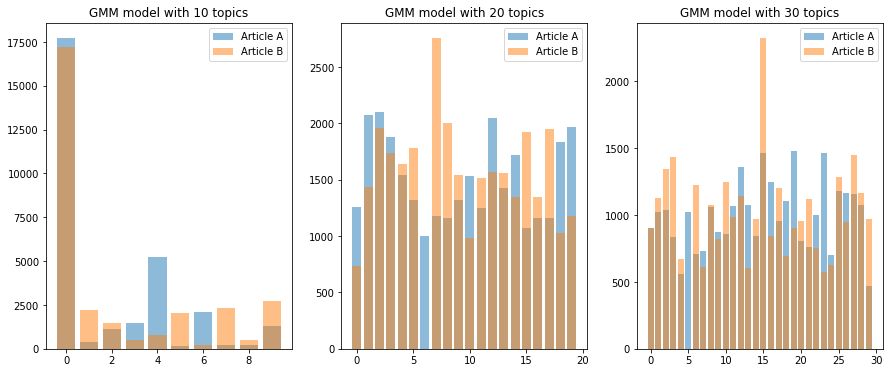

In [60]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 6)

axs[0].bar(unique110, counts110, alpha = 0.5, label = 'Article A')
axs[0].bar(unique210, counts210, alpha = 0.5, label = 'Article B')
axs[0].legend(loc='upper right')
axs[0].set_title("GMM model with 10 topics")
#plt.show()

axs[1].bar(unique120, counts120, alpha = 0.5, label = 'Article A')
axs[1].bar(unique220, counts220, alpha = 0.5, label = 'Article B')
axs[1].legend(loc='upper right')
axs[1].set_title("GMM model with 20 topics")
#plt.show()

axs[2].bar(unique130, counts130, alpha = 0.5, label = 'Article A')
axs[2].bar(unique230, counts230, alpha = 0.5, label = 'Article B')
axs[2].legend(loc='upper right')
axs[2].set_title("GMM model with 30 topics")
#

fig.show()

## Latent Dirichlet Allocation

In [61]:
trainLDA = df.copy()
trainLDA.head(5)

,Unnamed: 0,id,tid1,tid2,title1_en,title2_en,labelN,docA,docB
0,0,0,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,"['new', 'old', 'age', 'insurance', 'benefit', ...","['Police', 'disprove', 'bird', 'nest', 'congre..."
1,1,3,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['Shenzhen', 'gdp', 'outstrip', 'Hong', 'Kong'..."
2,2,1,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['GDP', 'overtop', 'Hong', 'Kong', 'Shenzhen',..."
3,3,2,2,5,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['Shenzhen', 'gdp', 'top', 'Hong', 'Kong', 'ye..."
4,4,9,6,7,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,related,"['discriminate', 'oil', 'gutter', 'oil', 'mean...","['take', 'year', 'cook', 'oil', 'know', 'piece..."


In [65]:

# Create a dictionary representation of the documents.

dictionaryA = Dictionary([trainLDA['docA']])
dictionaryB = Dictionary([trainLDA['docB']])
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionaryA.filter_extremes(no_below=20, no_above=0.5)
# dictionaryB.filter_extremes(no_below=20, no_above=0.5)


corpusA = [dictionaryA.doc2bow([doc]) for doc in trainLDA['docA']]
corpusB = [dictionaryB.doc2bow([doc]) for doc in trainLDA['docB']]

In [66]:
print('Number of unique tokens in article A: %d' % len(dictionaryA))
print('Number of documents in article A: %d' % len(corpusA))

print('Number of unique tokens in article B: %d' % len(dictionaryB))
print('Number of documents in article B: %d' % len(corpusB))

Number of unique tokens in article A: 6109
Number of documents in article A: 30000
Number of unique tokens in article B: 22251
Number of documents in article B: 30000


In [67]:
# Number of topics = 10
# for article A
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None
temp = dictionaryA[0]  # This is only to "load" the dictionary.
id2word = dictionaryA.id2token

LDA10A = LdaModel(
    corpus=corpusA,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

# for article A
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None
temp = dictionaryB[0]  # This is only to "load" the dictionary.
id2word = dictionaryB.id2token


LDA10B = LdaModel(
    corpus=corpusA,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [68]:
labelsLDA10A = []
labelsLDA10B = []
for i in range(len(corpusA)):
    labelsLDA10A.append(max(dict(LDA10A[corpusA[i]]), key=dict(LDA10A[corpusA[i]]).get))
    labelsLDA10B.append(max(dict(LDA10B[corpusB[i]]), key=dict(LDA10B[corpusB[i]]).get))

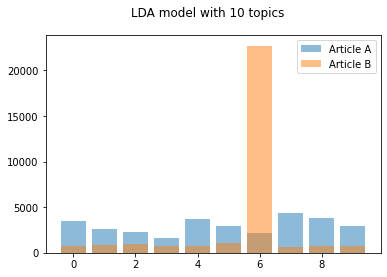

In [69]:
unique110, counts110 = np.unique(labelsLDA10A, return_counts=True)
unique210, counts210 = np.unique(labelsLDA10B, return_counts=True)
plt.bar(unique110, counts110, alpha = 0.5, label = 'Article A')
plt.bar(unique210, counts210, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("LDA model with 10 topics")
plt.show()

In [70]:
predLDA10 = predfun(labelsLDA10A, labelsLDA10B)
crLDA10 = classification_report(trainLDA['labelN'], predLDA10)
print(crLDA10)

              precision    recall  f1-score   support

     related       0.32      0.08      0.13      9102
   unrelated       0.70      0.93      0.80     20898

    accuracy                           0.67     30000
   macro avg       0.51      0.50      0.46     30000
weighted avg       0.58      0.67      0.59     30000



In [71]:
# Number of topics = 20
# for article A
num_topics = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None
temp = dictionaryA[0]  # This is only to "load" the dictionary.
id2word = dictionaryA.id2token

LDA20A = LdaModel(
    corpus=corpusA,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

# for article A
num_topics = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None
temp = dictionaryB[0]  # This is only to "load" the dictionary.
id2word = dictionaryB.id2token


LDA20B = LDA10A = LdaModel(
    corpus=corpusA,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)


In [72]:
labelsLDA20A = []
labelsLDA20B = []
for i in range(len(corpusA)):
    labelsLDA20A.append(max(dict(LDA20A[corpusA[i]]), key=dict(LDA20A[corpusA[i]]).get))
    labelsLDA20B.append(max(dict(LDA20B[corpusB[i]]), key=dict(LDA20B[corpusB[i]]).get))

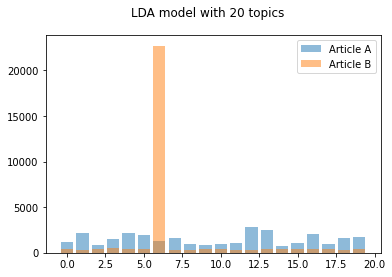

In [73]:
unique120, counts120 = np.unique(labelsLDA20A, return_counts=True)
unique220, counts220 = np.unique(labelsLDA20B, return_counts=True)
plt.bar(unique120, counts120, alpha = 0.5, label = 'Article A')
plt.bar(unique220, counts220, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("LDA model with 20 topics")
plt.show()

In [74]:
predLDA20 = predfun(labelsLDA20A, labelsLDA20B)
crLDA20 = classification_report(trainLDA['labelN'], predLDA20)
print(crLDA20)

              precision    recall  f1-score   support

     related       0.27      0.04      0.07      9102
   unrelated       0.69      0.95      0.80     20898

    accuracy                           0.67     30000
   macro avg       0.48      0.50      0.44     30000
weighted avg       0.57      0.67      0.58     30000



In [75]:
# Number of topics = 30
# for article A
num_topics = 30
chunksize = 2000
passes = 20
iterations = 400
eval_every = None
temp = dictionaryA[0]  # This is only to "load" the dictionary.
id2word = dictionaryA.id2token

LDA30A = LdaModel(
    corpus=corpusA,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

# for article B
num_topics = 30
chunksize = 2000
passes = 20
iterations = 400
eval_every = None
temp = dictionaryB[0]  # This is only to "load" the dictionary.
id2word = dictionaryB.id2token


LDA30B = LdaModel(
    corpus=corpusA,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [76]:
labelsLDA30A = []
labelsLDA30B = []
for i in range(len(corpusA)):
    labelsLDA30A.append(max(dict(LDA30A[corpusA[i]]), key=dict(LDA30A[corpusA[i]]).get))
    labelsLDA30B.append(max(dict(LDA30B[corpusB[i]]), key=dict(LDA30B[corpusB[i]]).get))

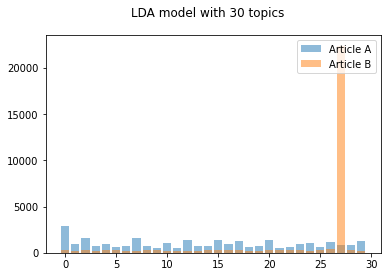

In [77]:
unique130, counts130 = np.unique(labelsLDA30A, return_counts=True)
unique230, counts230 = np.unique(labelsLDA30B, return_counts=True)
plt.bar(unique130, counts130, alpha = 0.5, label = 'Article A')
plt.bar(unique230, counts230, alpha = 0.5, label = 'Article B')
plt.legend(loc='upper right')
plt.suptitle("LDA model with 30 topics")
plt.show()

In [78]:
predLDA30 = predfun(labelsLDA30A, labelsLDA30B)
crLDA30 = classification_report(trainLDA['labelN'], predLDA30)
print(crLDA30)

              precision    recall  f1-score   support

     related       0.41      0.04      0.07      9102
   unrelated       0.70      0.98      0.82     20898

    accuracy                           0.69     30000
   macro avg       0.56      0.51      0.44     30000
weighted avg       0.61      0.69      0.59     30000



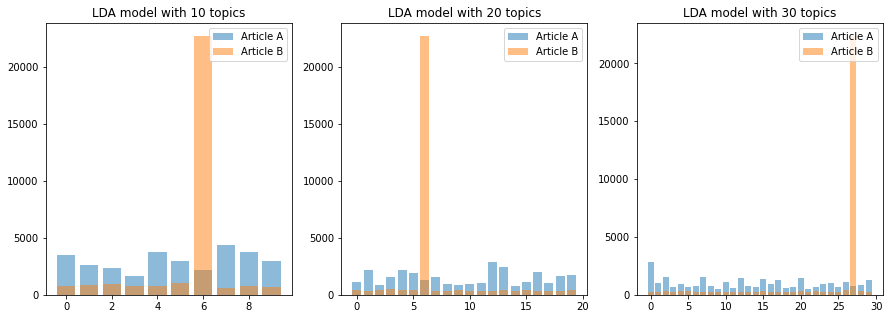

In [79]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)

axs[0].bar(unique110, counts110, alpha = 0.5, label = 'Article A')
axs[0].bar(unique210, counts210, alpha = 0.5, label = 'Article B')
axs[0].legend(loc='upper right')
axs[0].set_title("LDA model with 10 topics")
#plt.show()

axs[1].bar(unique120, counts120, alpha = 0.5, label = 'Article A')
axs[1].bar(unique220, counts220, alpha = 0.5, label = 'Article B')
axs[1].legend(loc='upper right')
axs[1].set_title("LDA model with 20 topics")
#plt.show()

axs[2].bar(unique130, counts130, alpha = 0.5, label = 'Article A')
axs[2].bar(unique230, counts230, alpha = 0.5, label = 'Article B')
axs[2].legend(loc='upper right')
axs[2].set_title("LDA model with 30 topics")
#

fig.show()

# Semantic-based Approches - Embedding 

## Word2Vec - Semantic similarity

In [8]:
df = pd.read_csv('data_preprocessed.csv')

In [10]:
trainSim = df.copy()
trainSim.head(5)

,Unnamed: 0,id,tid1,tid2,title1_en,title2_en,labelN,docA,docB
0,0,0,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,"['new', 'old', 'age', 'insurance', 'benefit', ...","['Police', 'disprove', 'bird', 'nest', 'congre..."
1,1,3,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['Shenzhen', 'gdp', 'outstrip', 'Hong', 'Kong'..."
2,2,1,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['GDP', 'overtop', 'Hong', 'Kong', 'Shenzhen',..."
3,3,2,2,5,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated,"['come', 'Shenzhen', 'sooner', 'later', 'son',...","['Shenzhen', 'gdp', 'top', 'Hong', 'Kong', 'ye..."
4,4,9,6,7,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,related,"['discriminate', 'oil', 'gutter', 'oil', 'mean...","['take', 'year', 'cook', 'oil', 'know', 'piece..."


In [82]:
# def simple_similarity(doc1, doc2):
#   return nlp(doc1).similarity(nlp(doc2))

def simple_similarity(data, threshold):
  simPred = []
  for row in data.itertuples():
    sim = nlp(row.title1_en).similarity(nlp(row.title2_en))
    if sim >threshold:
      simPred.append('related')
    else:
      simPred.append('unrelated')
  return simPred

In [87]:
for row in trainSim[:4].itertuples():
  print(nlp(row.title1_en).similarity(nlp(row.title2_en)))

0.8650409639154647
0.7679156402609217
0.805876120360961
0.7494941460216636


/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
No handles with labels found to put in legend.


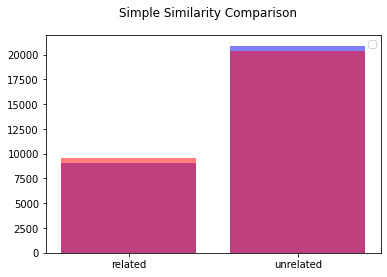

              precision    recall  f1-score   support

     related       0.58      0.61      0.59      9102
   unrelated       0.82      0.80      0.81     20898

    accuracy                           0.74     30000
   macro avg       0.70      0.71      0.70     30000
weighted avg       0.75      0.74      0.75     30000



In [88]:
# threshold = 0.9
simPred = simple_similarity(trainSim, 0.9) 

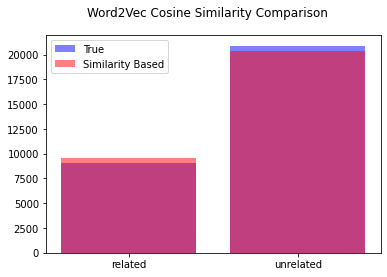

              precision    recall  f1-score   support

     related       0.58      0.61      0.59      9102
   unrelated       0.82      0.80      0.81     20898

    accuracy                           0.74     30000
   macro avg       0.70      0.71      0.70     30000
weighted avg       0.75      0.74      0.75     30000



In [98]:
unique1, counts1 = np.unique(trainSim['labelN'], return_counts=True)
unique2, counts2 = np.unique(simPred, return_counts=True)
plt.bar(unique1, counts1, alpha = 0.5, color = 'blue', label = "True")
plt.bar(unique2, counts2, alpha = 0.5, color = 'red', label = "Similarity Based")
plt.legend(loc='upper left')
plt.suptitle("Word2Vec Cosine Similarity Comparison")
plt.show()


crSim = classification_report(trainSim['labelN'], simPred) 
print(crSim)


In [ ]:
# simple_sim = pd.DataFrame({'scores': simPred})
# simple_sim.to_csv('simpleSimilarity.csv')

## Using word2vec and Transformer

In [90]:
from functools import reduce
def transformer(sentence):
        return reduce(lambda x,y: x+y, [nlp.vocab[w].vector for w in sentence])

def cosine_sim(arr1, arr2):
  return np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))

def similarity(doc1, doc2):
  doc1arr = transformer(doc1)
  doc2arr = transformer(doc2)
  return cosine_sim(doc1arr, doc2arr) 


def similarity_predict(data, threshold):
  simPred = []
  for row in data.itertuples():
    sim = similarity(row.docA, row.docB)
    if sim >threshold:
      simPred.append('related')
    else:
      simPred.append('unrelated')
  return simPred

No handles with labels found to put in legend.


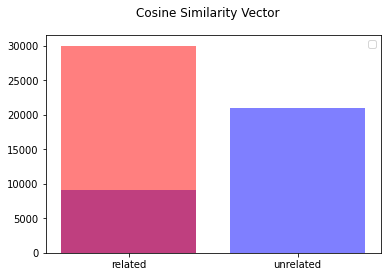

              precision    recall  f1-score   support

     related       0.30      1.00      0.47      9102
   unrelated       0.89      0.00      0.00     20898

    accuracy                           0.30     30000
   macro avg       0.60      0.50      0.23     30000
weighted avg       0.71      0.30      0.14     30000



In [91]:
# for threshold 0.5
simPred5 = similarity_predict(trainSim, 0.5)


unique1, counts1 = np.unique(trainSim['labelN'], return_counts=True)
unique2, counts2 = np.unique(simPred5, return_counts=True)
plt.bar(unique1, counts1, alpha = 0.5, color = 'blue')
plt.bar(unique2, counts2, alpha = 0.5, color = 'red')
plt.legend(loc='upper right')
plt.suptitle("Cosine Similarity Vector")
plt.show()


crSim = classification_report(trainSim['labelN'], simPred5) 
print(crSim)

In [92]:
Counter(simPred5)

Counter({'related': 29982, 'unrelated': 18})

No handles with labels found to put in legend.


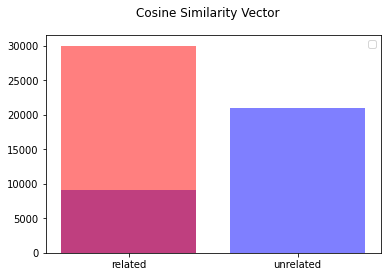

              precision    recall  f1-score   support

     related       0.30      1.00      0.47      9102
   unrelated       0.89      0.00      0.00     20898

    accuracy                           0.30     30000
   macro avg       0.60      0.50      0.23     30000
weighted avg       0.71      0.30      0.14     30000



In [93]:
# for threshold 0.7
simPred7 = similarity_predict(trainSim, 0.7)


unique1, counts1 = np.unique(trainSim['labelN'], return_counts=True)
unique2, counts2 = np.unique(simPred7, return_counts=True)
plt.bar(unique1, counts1, alpha = 0.5,color = 'blue')
plt.bar(unique2, counts2, alpha = 0.5, color = 'red')
plt.legend(loc='upper right')
plt.suptitle("Cosine Similarity Vector")
plt.show()


crSim = classification_report(trainSim['labelN'], simPred7) 
print(crSim)

In [94]:
Counter(simPred7)

Counter({'related': 29982, 'unrelated': 18})

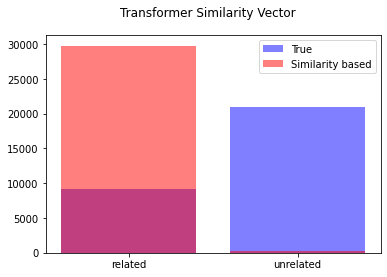

              precision    recall  f1-score   support

     related       0.30      0.99      0.47      9102
   unrelated       0.77      0.01      0.02     20898

    accuracy                           0.31     30000
   macro avg       0.54      0.50      0.24     30000
weighted avg       0.63      0.31      0.15     30000



In [99]:
# for threshold 0.95
simPred95 = similarity_predict(trainSim, 0.95)


unique1, counts1 = np.unique(trainSim['labelN'], return_counts=True)
unique2, counts2 = np.unique(simPred95, return_counts=True)
plt.bar(unique1, counts1, alpha = 0.5,color = 'blue', label = "True")
plt.bar(unique2, counts2, alpha = 0.5, color = 'red', label = "Similarity based")
plt.legend(loc='upper right')
plt.suptitle("Transformer Similarity Vector")
plt.show()


crSim = classification_report(trainSim['labelN'], simPred95) 
print(crSim)

In [96]:
Counter(simPred95)

Counter({'related': 29769, 'unrelated': 231})

## Using doc2vec

In [11]:
superdoc = [row.docA for row in trainSim.itertuples()]
for row in trainSim.itertuples():
  superdoc.append(row.docB)

len(superdoc)

60000

In [12]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(superdoc)]
d2vmodel = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [13]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("my_doc2vec_model")
d2vmodel.save(fname)
d2vmodel = Doc2Vec.load(fname)  

In [14]:
from scipy.spatial import distance

def doc2vec_similarity(data,threshold):
  simPred = []
  for row in data.itertuples():
    vec1 = d2vmodel.infer_vector(row.docA)
    vec2 = d2vmodel.infer_vector(row.docB)
    cos_distance = distance.cosine(vec1, vec2)
    if cos_distance >threshold:
      simPred.append('related')
    else:
      simPred.append('unrelated')
  return simPred


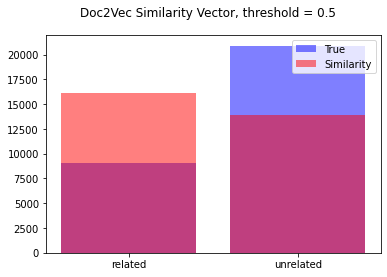

              precision    recall  f1-score   support

     related       0.27      0.48      0.35      9102
   unrelated       0.66      0.44      0.53     20898

    accuracy                           0.45     30000
   macro avg       0.47      0.46      0.44     30000
weighted avg       0.54      0.45      0.48     30000



In [17]:
# for threshold 0.5
doc2vecPred5 = doc2vec_similarity(trainSim, 0.5)


unique1, counts1 = np.unique(trainSim['labelN'], return_counts=True)
unique2, counts2 = np.unique(doc2vecPred5, return_counts=True)
plt.bar(unique1, counts1, alpha = 0.5, color = 'blue', label = "True")
plt.bar(unique2, counts2, alpha = 0.5, color = 'red', label = "Similarity")
plt.legend(loc='upper right')
plt.suptitle("Doc2Vec Similarity Vector, threshold = 0.5")
plt.show()


crSim = classification_report(trainSim['labelN'], doc2vecPred5) 
print(crSim)

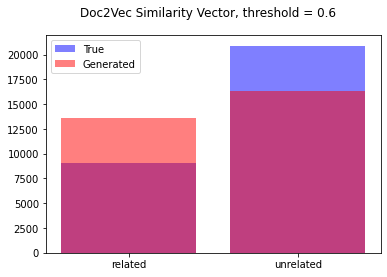

              precision    recall  f1-score   support

     related       0.27      0.40      0.32      9102
   unrelated       0.67      0.52      0.59     20898

    accuracy                           0.49     30000
   macro avg       0.47      0.46      0.45     30000
weighted avg       0.55      0.49      0.51     30000



In [18]:
# for threshold 0.6
doc2vecPred6 = doc2vec_similarity(trainSim, 0.6)


unique1, counts1 = np.unique(trainSim['labelN'], return_counts=True)
unique2, counts2 = np.unique(doc2vecPred6, return_counts=True)
plt.bar(unique1, counts1, alpha = 0.5, color = 'blue', label = 'True')
plt.bar(unique2, counts2, alpha = 0.5, color = 'red', label = 'Generated')
plt.legend(loc='upper left')
plt.suptitle("Doc2Vec Similarity Vector, threshold = 0.6")
plt.show()


crSim = classification_report(trainSim['labelN'], doc2vecPred6) 
print(crSim)

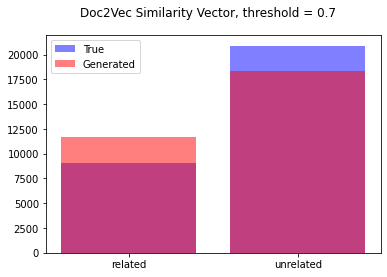

              precision    recall  f1-score   support

     related       0.26      0.34      0.30      9102
   unrelated       0.67      0.59      0.63     20898

    accuracy                           0.51     30000
   macro avg       0.47      0.46      0.46     30000
weighted avg       0.55      0.51      0.53     30000



In [15]:
# for threshold 0.7
doc2vecPred7 = doc2vec_similarity(trainSim, 0.7)

unique1, counts1 = np.unique(trainSim['labelN'], return_counts=True)
unique2, counts2 = np.unique(doc2vecPred7, return_counts=True)
plt.bar(unique1, counts1, alpha = 0.5, color = 'blue', label = 'True')
plt.bar(unique2, counts2, alpha = 0.5, color = 'red', label = 'Generated')
plt.legend(loc='upper left')
plt.suptitle("Doc2Vec Similarity Vector, threshold = 0.7")
plt.show()


crSim = classification_report(trainSim['labelN'], doc2vecPred7) 
print(crSim)

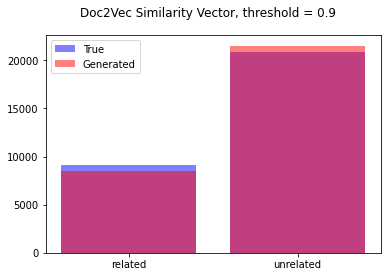

              precision    recall  f1-score   support

     related       0.25      0.23      0.24      9102
   unrelated       0.67      0.69      0.68     20898

    accuracy                           0.55     30000
   macro avg       0.46      0.46      0.46     30000
weighted avg       0.55      0.55      0.55     30000



In [16]:
# for threshold 0.9
doc2vecPred9 = doc2vec_similarity(trainSim, 0.9)

unique1, counts1 = np.unique(trainSim['labelN'], return_counts=True)
unique2, counts2 = np.unique(doc2vecPred9, return_counts=True)
plt.bar(unique1, counts1, alpha = 0.5, color = 'blue', label = 'True')
plt.bar(unique2, counts2, alpha = 0.5, color = 'red', label = 'Generated')
plt.legend(loc='upper left')
plt.suptitle("Doc2Vec Similarity Vector, threshold = 0.9")
plt.show()


crSim = classification_report(trainSim['labelN'], doc2vecPred9) 
print(crSim)